In [ ]:
from PIL import Image, ImageOps
import numpy as np

In [ ]:
galia = Image.open('galia_e.png')
galia_matrix = np.asarray(galia)
galia_inverted = ImageOps.invert(galia.convert('L'))
galia_matrix_inverted = np.asarray(galia_inverted)
galia_matrix_inverted = np.abs(galia_matrix_inverted)

full_text = Image.open('full_text1.png')
full_text_matrix = np.asarray(full_text)
full_text_inverted = ImageOps.invert(full_text.convert('L'))
full_text_matrix_inverted = np.asarray(full_text_inverted)
full_text_matrix_inverted = np.abs(full_text_matrix_inverted)

In [ ]:
def compute_C(full_matrix_inverted, pattern_matrix_inverted):
    return np.real(np.fft.ifft2(np.fft.fft2(full_matrix_inverted) * np.fft.fft2(np.rot90(pattern_matrix_inverted, 2),
                                                                                     full_matrix_inverted.shape)))

C = compute_C(full_text_matrix_inverted, galia_matrix_inverted)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

def plot_3d(matrix):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    X = np.arange(0, matrix.shape[0], 1)
    Y = np.arange(0, matrix.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, matrix.transpose(), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

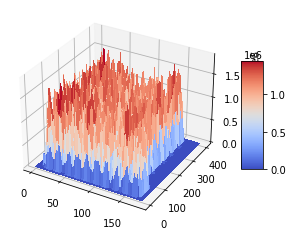

In [ ]:
plot_3d(C)

In [ ]:
from copy import copy

def get_highest_values(matrix, threshold):
    matrix = copy(matrix)
    highest_value = np.amax(matrix)
    print(highest_value)
    counter = 0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] < threshold * highest_value:
                matrix[i, j] = 0
            else:
                counter += 1

    return matrix, counter

1889960.9999999984
14


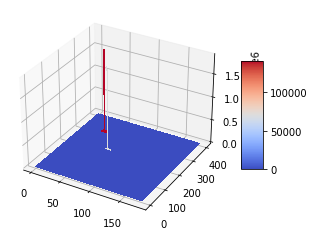

In [ ]:
highest_values_matrix, counter = get_highest_values(C, 0.9577)
print(counter)
plot_3d(highest_values_matrix)

In [ ]:
def mark_occurrences(C, image, pattern, threshold):
    C = C.transpose()
    img = image.load()
    threshold = threshold * (np.max(C) - np.min(C)) + np.min(C)
    for x, y in np.argwhere(C >= threshold):
        for w in range(pattern.size[0]):
            for h in range(pattern.size[1]):
                # if 0 <= x - w < image.size[0] and 0 <= y - h < image.size[1]:
                r, g, b = img[x - w, y - h]
                img[x - w, y - h] = (r - 100, g - 100,b - 100)
    image.save(f"results/{pattern.filename}")

In [ ]:
mark_occurrences(C, full_text, galia, 0.9)

galia_e.png


In [ ]:
def relative_C(full_image_matrix_inverted, pattern_matrix_inverted):
    C_pattern = np.max(np.real(
            np.fft.ifft2(
                np.multiply(
                    np.fft.fft2(pattern_matrix_inverted),
                    np.fft.fft2(np.rot90(pattern_matrix_inverted, 2))
                ))))

    C = np.abs(np.real(
            np.fft.ifft2(
                np.multiply(
                    np.fft.fft2(full_image_matrix_inverted),
                    np.fft.fft2(np.rot90(pattern_matrix_inverted, 2), s=full_image_matrix_inverted.shape)
                ))) / C_pattern - 1)

    return C

In [ ]:
from math import floor
from PIL import ImageFont, ImageDraw

def ocr(font_type, font_size, full_image_path, threshold_percentage):
    font = ImageFont.truetype(fr"C:\Windows\Fonts\{font_type}.ttf", font_size)
    all_characters = "abcdefghijklmnopqrstuvwxyz1234567890?!.,"
    char_sample_width, char_sample_height = font.getsize('e')
    full_image = Image.open(full_image_path)
    full_image_matrix_inverted = np.asarray(ImageOps.invert(full_image.convert('L')))
    character_coordinates = []
    for character in all_characters:
        width, height = font.getsize(character)
        character_image = Image.new('RGB', (width, height), color=(255, 255, 255))
        d = ImageDraw.Draw(character_image)
        d.text(xy=(0, 0), text=character, fill=(0, 0, 0), font=font)
        ImageOps.expand(character_image, border=2, fill=(255, 255, 255))
        character_matrix_inverted = np.asarray(ImageOps.invert(character_image.convert('L')))

        C = relative_C(full_image_matrix_inverted, character_matrix_inverted)

        for y, x in np.argwhere(C < 1e-5):
            character_coordinates.append((x, y, character))

    print(character_coordinates)
    text = dict()
    print(char_sample_width)
    width_of_space, _ = font.getsize(" ")

    for character_coordinate in character_coordinates:
        x, y, char = character_coordinate
        if y // char_sample_height in text.keys():
            if not x / char_sample_width in (pos[0] for pos in text[y // char_sample_height]):
                text[y // char_sample_height].append((x / char_sample_width, char))
        else:
            text[y // char_sample_height] = [(x / char_sample_width, char)]

    recognised_text = ""

    for n in text.keys():
        line = text[n]
        line = sorted(line, key=lambda t: t[0])
        last_char_x = 2
        for (coord, character) in line:
            if coord - last_char_x > 0.7 * char_sample_width / width_of_space:
                recognised_text += " " * floor(coord - last_char_x) + character
            else:
                recognised_text += character
            last_char_x = coord
        recognised_text += "\n "

    return recognised_text

In [ ]:
print(repr(ocr("Arial", 40, "generated_texts/Arial.png", 1)))


[(206, 56, 'a'), (87, 97, 'd'), (131, 97, 'e'), (171, 64, 'g'), (52, 56, 'h'), (61, 56, 'i'), (171, 97, 'i'), (334, 56, 'k'), (407, 56, 'k'), (239, 56, 'm'), (149, 56, 'o'), (301, 56, 'o'), (387, 56, 'o'), (41, 97, 'o'), (109, 97, 'o'), (114, 64, 'p'), (128, 56, 'r'), (185, 56, 'r'), (315, 56, 'r'), (55, 97, 'r'), (81, 56, 's'), (354, 56, 's'), (151, 97, 's'), (30, 56, 't'), (182, 97, 't'), (279, 56, 'w'), (204, 97, '?'), (88, 97, ',')]
22
'this progra m works ok\n or d,oesit?\n '


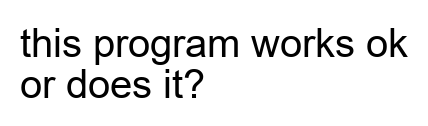

